# Kernel density estimation bandwidth selection
**TLDR**

Here are the final recommendations for kernel density estimation based on the experiments below:

1. Use parallelism over input data to speed up evaluation when needed.
2. Use package *scipy.stats gaussian_kde* for speed advantage over scikit-learn in kernel density estimation and scale invariance.
3. Use Silverman rule-of-thumb bandwidth estimation - fit looks good compared to time/effort spent optimizing the bandwidth for each case.

**N.B.**: Scikit-learn's *KernelDensity* appears to be sensitive to scale - performance is **much** better on standard scaled data than raw data.

**TODO**
This should be in benchmarking.

**Notebook description**

In the following notebooks, two engineered features will be introduced. Both are based on the Kullback-Leibler divergence (KLD) of the distributions of the underlying feature in human and synthetic text. Kernel density estimation (KDE) will be used to recover the distributions of both the underlying features and then the Kullback-Leibler divergence. Therefore, it is important to do a reasonable job of kernel density estimation. The individual features should not be too hard - they are all approximately normally distributed - in fact, a gaussian fits well enough. But, improvements can be made, especially so in the case of the KLD which is not easily modeled by an 'off the shelf' statistical distribution. In early experiments, kernel density estimation has done a reasonable job, however:

1. It's slow, possibly due to poorly specified bandwidth or kernel.
2. Default values are used for kernel type and bandwidth.
3. There are two options for gaussian kernel density estimation: SciPy's *gaussian_kde* and SciKit-Learn's *KernelDensity*.

The plan is to test these factors with real data and make some informed choices about the best strategy moving forward.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

Working directory: /mnt/arkk/llm_detector/classifier


In [2]:
# The dataset to load - omit the file extension
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

## 2. Load and prepare the data
Load and prepare some data to test on. Rather than working with all of the length bins, the combined training dataset will be used for testing purposes.

<class 'pandas.core.frame.DataFrame'>
Index: 5577 entries, 0 to 5576
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment ID               5577 non-null   int64  
 1   Source record num         5577 non-null   int64  
 2   Fragment length (words)   5577 non-null   int64  
 3   Fragment length (tokens)  5577 non-null   int64  
 4   Dataset                   5577 non-null   object 
 5   Source                    5577 non-null   object 
 6   Generator                 5577 non-null   object 
 7   String                    5577 non-null   object 
 8   Perplexity                5577 non-null   float64
 9   Cross-perplexity          5577 non-null   float64
 10  Perplexity ratio score    5577 non-null   float64
 11  Reader time (seconds)     5577 non-null   float64
 12  Writer time (seconds)     5577 non-null   float64
 13  Reader peak memory (GB)   5577 non-null   float64
 14  Writer peak m

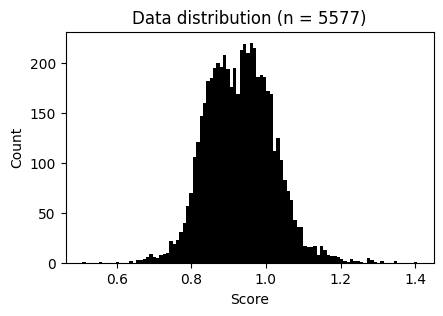

In [3]:
# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(input_file)

# Load the dataframe
data_df = data_lake['master']

# Close the connection to the data lake
data_lake.close()

# Take a look
data_df.info()

# Get the perplexity ratio score data
data = np.asarray(data_df['Perplexity ratio score'])

# Show a quick histogram
plt.figure(figsize = (4.75, 3))
plt.title(f'Data distribution (n = {len(data)})')
plt.hist(data, bins = 100, color = 'black')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

## 3. Visual comparison of fits: bandwidth

### 3.1 Raw data

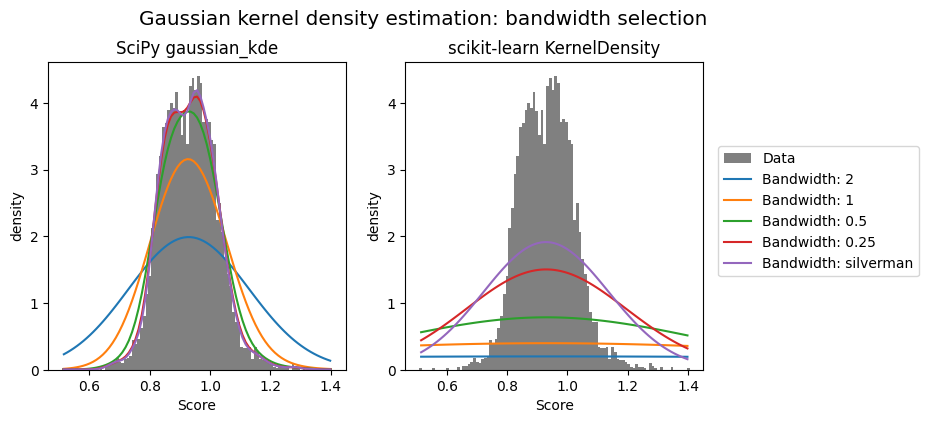

In [4]:
result = helper_funcs.kde_bandwidth_scan(
    data = data,
    bandwidths = [2, 1, 0.5, 0.25, 'silverman']
)

plot_funcs.plot_bandwidth_scan(result, data).show()

### 3.2 Standardized data

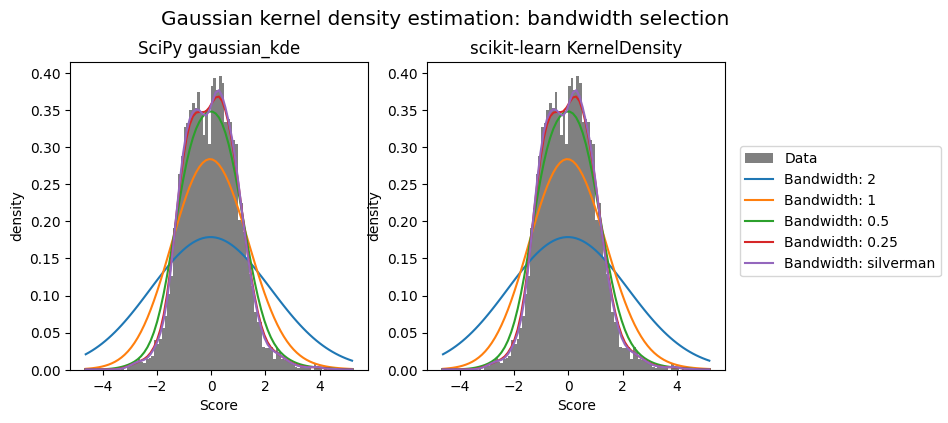

In [5]:
feature_scaler = StandardScaler().fit(np.asarray(data_df['Perplexity ratio score']).reshape(-1, 1))
scaled_data = feature_scaler.transform(np.asarray(data_df['Perplexity ratio score']).reshape(-1, 1))

result = helper_funcs.kde_bandwidth_scan(
    data = scaled_data,
    bandwidths = [2, 1, 0.5, 0.25, 'silverman']
)

plot_funcs.plot_bandwidth_scan(result, scaled_data).show()

That was unexpected - The results from scikit-learn and SciPy look identical, but only if the data is standard scaled! Scikit-learn seems to require standard scaled data? Don't have time to dig into why right now, but word-to-the-wise, if you are going to use scikit-learn for kernel density estimation, be sure to convert your data to Z-scores first. 

Also, the silverman bandwidth estimate look perfectly fine. Not convinced there is much improvement to be had by fine tuning the bandwidth using cross-validation or the like. Let's move on to speed.

## 4. KDE speed
Using the Silverman rule for bandwidth, measure the dependence of KDE speed on dataset size. There are two parts to this:
1. Speed of kernel density estimation vs dataset size
2. Speed of fitted value calculation vs number of evaluation points (this should scale linearly)

### 4.1. Kernel density estimation speed vs dataset size

In [6]:
sample_sizes = [500, 1000, 2000, 4000, 8000, 16000]

result = helper_funcs.kde_speed(
    data = data,
    sample_sizes = sample_sizes
)

result = pd.DataFrame(result)
result.head()

,Replicate,Package,Sample size,Mean time (sec.),Standard deviation
0,49,SciPy,500,0.000409,0.000162
1,49,scikit-learn,500,0.000602,0.000194
2,49,SciPy,1000,0.000349,0.000043
3,49,scikit-learn,1000,0.000604,0.000025
4,49,SciPy,2000,0.000352,0.000009


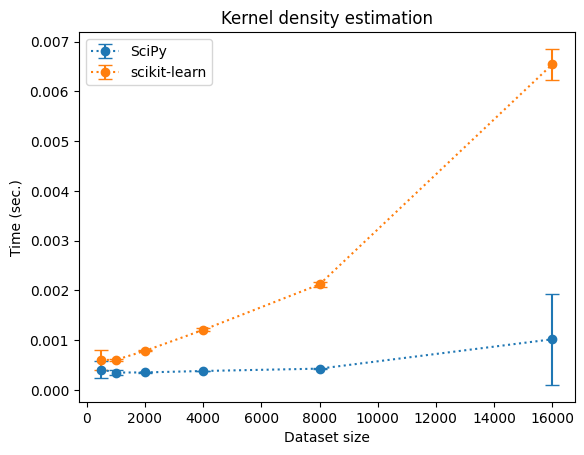

In [7]:
plt.title('Kernel density estimation')
plt.xlabel('Dataset size')
plt.ylabel('Time (sec.)')

scipy_data = result[result['Package'] == 'SciPy']

plt.errorbar(
    scipy_data['Sample size'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'SciPy'
)

scipy_data = result[result['Package'] == 'scikit-learn']

plt.errorbar(
    scipy_data['Sample size'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'scikit-learn'
)

plt.legend(loc = 'upper left')
plt.show()

Scipy has much better scaling characteristics. Scikit-learn starts to slow down significantly as the dataset grows.

### 4.2. Fitted value calculation speed vs number of evaluation points

In [8]:
n_eval_points = [500, 1000, 2000, 4000, 8000, 16000]

result = helper_funcs.fitted_value_speed(
    data = data,
    n_eval_points = n_eval_points
)

result = pd.DataFrame(result)
result.head()

,Replicate,Package,Evaluation points,Mean time (sec.),Standard deviation
0,4,SciPy,500,0.094149,0.006925
1,4,scikit-learn,500,0.198316,0.000907
2,4,SciPy,1000,0.138561,0.000506
3,4,scikit-learn,1000,0.391439,0.005172
4,4,SciPy,2000,0.244075,0.011329


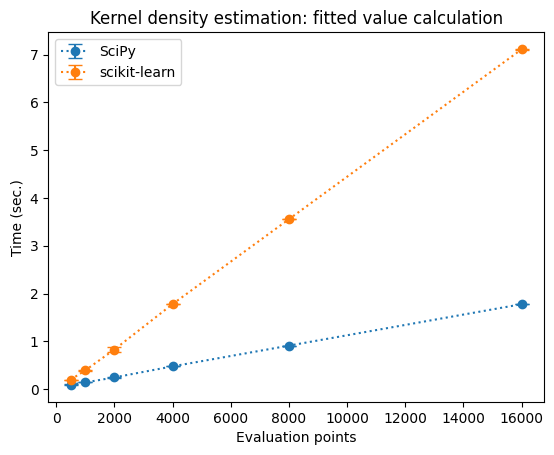

In [9]:
plt.title('Kernel density estimation: fitted value calculation')
plt.xlabel('Evaluation points')
plt.ylabel('Time (sec.)')

scipy_data = result[result['Package'] == 'SciPy']

plt.errorbar(
    scipy_data['Evaluation points'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'SciPy'
)

scipy_data = result[result['Package'] == 'scikit-learn']

plt.errorbar(
    scipy_data['Evaluation points'], 
    scipy_data['Mean time (sec.)'], 
    yerr = scipy_data['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5,
    label = 'scikit-learn'
)

plt.legend(loc = 'upper left')
plt.show()

Not as big of a difference for evaluation speed, but SciPy is slightly better. Here are the recommendations so far:
1. Package *scipy.stats gaussian_kde*
2. Bandwidth: Silverman rule-of-thumb estimation

### 4.3. Fitted value calculation: data parallelism
Can we speed up evaluation by breaking the points into chunks and evaluating them in parallel?

In [11]:
worker_counts = [1, 2, 4, 8, 16]

result = helper_funcs.eval_speed_worker_count(
    data = data,
    worker_counts = worker_counts, 
    replicates = 3
)

result = pd.DataFrame(result)
result.head()

,Replicate,Workers,Mean time (sec.),Standard deviation
0,2,1,1.821046,0.011445
1,2,2,0.969115,0.019939
2,2,4,0.645770,0.022753
3,2,8,0.479973,0.016960
4,2,16,0.497228,0.036720


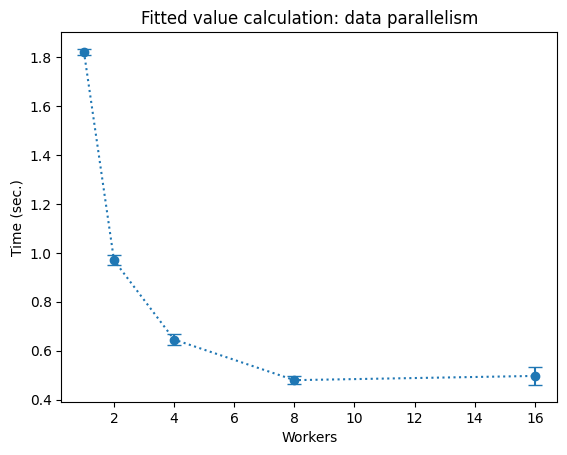

In [12]:
plt.title('Fitted value calculation: data parallelism')
plt.xlabel('Workers')
plt.ylabel('Time (sec.)')

plt.errorbar(
    result['Workers'], 
    result['Mean time (sec.)'], 
    yerr = result['Standard deviation'], 
    linestyle = 'dotted', 
    marker = 'o', 
    capsize = 5
)

plt.show()

Nice! Excellent speed-up with increased worker count.
## 5. Conclusion
Here are the final recommendations based on the above experiments:

1. Use parallelism over input data to speed up evaluation when needed.
2. Use package *scipy.stats Gaussian_kde* for speed advantage in kernel density estimation and scale invariance
3. Silverman rule-of-thumb bandwidth estimation - fit looks good compared to time/effort spent optimizing the bandwidth for each case